/home/jovyan/SInCohMap_EigenClassification/./Datasets/
/home/jovyan/SInCohMap_EigenClassification/./Classification_maps/
Appending /home/jovyan/SInCohMap_EigenClassification/./Datasets/WIELKOPOLSKA_RR_4x19_UTM_2016-01-01_2016-07-01_eigValuesVV.tiff file...
Appending /home/jovyan/SInCohMap_EigenClassification/./Datasets/WIELKOPOLSKA_RR_4x19_UTM_2016-07-01_2016-12-31_eigValuesVV.tiff file...
Appending /home/jovyan/SInCohMap_EigenClassification/./Datasets/WIELKOPOLSKA_RR_4x19_UTM_2016-01-01_2016-07-01_eigValuesVH.tiff file...
Appending /home/jovyan/SInCohMap_EigenClassification/./Datasets/WIELKOPOLSKA_RR_4x19_UTM_2016-07-01_2016-12-31_eigValuesVH.tiff file...
Elapsed time loading: 
2.474269151687622
/home/jovyan/Training_Data

        ################################
        General info about the shapefile
        ################################
        
Dataset driver is: ESRI Shapefile

The shapefile has 1 layer(s)

The layer is named: SInCohMap_WW_Validation_RR_WGS84_H33

The layer's

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


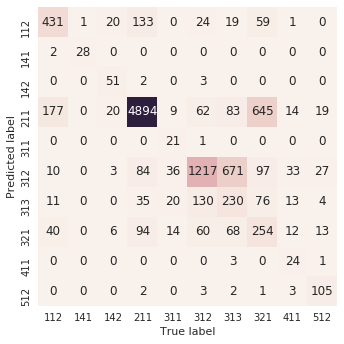


Classification report: 
precision = producer accuracy 
recall = user accuracy 
             precision    recall  f1-score   support

Class 112.0       0.63      0.64      0.63       671
Class 141.0       0.93      0.97      0.95        29
Class 142.0       0.91      0.51      0.65       100
Class 211.0       0.83      0.93      0.88      5244
Class 311.0       0.95      0.21      0.34       100
Class 312.0       0.56      0.81      0.66      1500
Class 313.0       0.44      0.21      0.29      1076
Class 321.0       0.45      0.22      0.30      1132
Class 411.0       0.86      0.24      0.38       100
Class 512.0       0.91      0.62      0.74       169

avg / total       0.69      0.72      0.69     10121

Feature ranking:
1. feature 10 (0.041955)
2. feature 26 (0.038348)
3. feature 27 (0.036060)
4. feature 25 (0.035322)
5. feature 28 (0.031277)
6. feature 9 (0.030939)
7. feature 24 (0.030881)
8. feature 8 (0.023795)
9. feature 11 (0.023404)
10. feature 12 (0.023375)
11. feature 22 

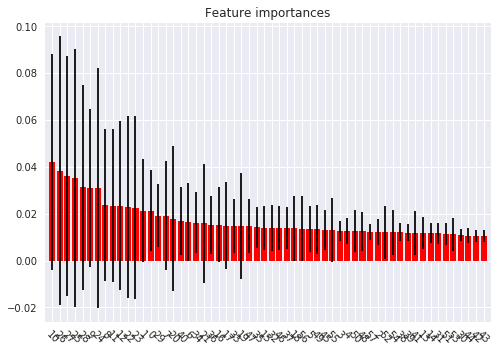


Overall Classification accuracy: 0.716826

Kappa score: 0.563290

Mc Nemars test
Chi-square 824.000000 P-value 0.000000

Everything worked out just fine, congrats :)


In [1]:
from geo_utils import write_geotiff
from landcover_classification import prepare_training_data, classification, validation, plot_classified_image 
import os, shutil
import inout
import numpy as np
from osgeo import gdal
import time

start = time.time()

## ---------------------------------------------------------------------------------------------------------------
## ---------------------------------------------------------------------------------------------------------------
## -------- CLASSIFICATION: VV EIGENVALUES BASED --------------------------------------------------------------------
## ---------------------------------------------------------------------------------------------------------------
## ---------------------------------------------------------------------------------------------------------------
selSet = "WIELKOPOLSKA_RR_4x19_UTM"

class_method = 'rf' # or 'svm'

RR_reference_dir = '../Training_Data/'
#vector_path = os.path.join(RR_reference_dir,'SInCohMap_Donyana_Validation_RR_WGS84_H30_vf.shp')
#vector_path = os.path.join(RR_reference_dir,'SInCohMap_STyrol_Validation_RR_WGS84_H32.shp')
vector_path = os.path.join(RR_reference_dir,'SInCohMap_WW_Validation_RR_WGS84_H33.shp')

idir = os.path.join(os.getcwd(), './Datasets/')
odir = os.path.join(os.getcwd(),'./Classification_maps/')

print(idir)
print(odir)

#geo_proj = inout.getProjection(selSet)
#geo_transf = inout.getGeoTransform(selSet)

datafiles = [os.path.join(idir,selSet + '_' + '2016-01-01_2016-07-01' + '_eigValuesVV.tiff'), \
             os.path.join(idir,selSet + '_' + '2016-07-01_2016-12-31' + '_eigValuesVV.tiff'), \
             os.path.join(idir,selSet + '_' + '2016-01-01_2016-07-01' + '_eigValuesVH.tiff'), \
             os.path.join(idir,selSet + '_' + '2016-07-01_2016-12-31' + '_eigValuesVH.tiff')]

tmdatafile = os.path.join(idir,selSet + '_stacked_2016S1S2_VVVH.tiff')
                          
tmdata = []
for ff in datafiles:
    print('Appending ' + ff + ' file...')
    raster_dataset = gdal.Open(ff, gdal.GA_ReadOnly)
    geo_proj = raster_dataset.GetProjection()
    geo_transf = raster_dataset.GetGeoTransform()
    for b in range(1, raster_dataset.RasterCount + 1):
        data = raster_dataset.GetRasterBand(b)
        tmdata.append(data.ReadAsArray())
                          
tmdata = np.dstack(tmdata)
write_geotiff(tmdatafile, tmdata, geo_transf, geo_proj)

column      = 'LEVEL_3'
nr_points   = 10000
sampling_methodology = 'proportional'

load_end = time.time()
print('Elapsed time loading: ')
print(load_end - start)

## SAMPLE
[training_samples, training_labels, bands_data, projection, geo_transform, is_test, test_labels, test_samples] = prepare_training_data(vector_path, tmdatafile, column, nr_points, sampling_methodology)

training_end = time.time()
print('Elapsed time training: ')
print(training_end - load_end)

## CLASSIFY
[classified_image, classifier] = classification(training_samples, training_labels, test_labels, test_samples, bands_data, geo_proj, geo_transf, classifier=class_method)

classif_end = time.time()
print('Elapsed time classifying: ')
print(classif_end-training_end)

oimage = 'classified_' + column + '_S' + str(nr_points) + sampling_methodology + '_' + class_method + '_' + os.path.basename(tmdatafile)
shutil.move('classified_image.tiff',os.path.join(odir, oimage))

## VALIDATE

validation(classified_image, is_test, test_labels, training_samples, classifier)